# Compute Intersubject Representational Similarity Analysis (IS-RSA)

## Set up environment

In [1]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

%matplotlib inline

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
os.getcwd()

'/project/3013104.01/scripts'

In [3]:
# Get the current working directory
current_directory = os.getcwd()

# Get the parent directory by using the os.path.dirname() function
parent_directory = os.path.dirname(current_directory)

# Change the working directory to the main project directory
os.chdir(parent_directory)
os.getcwd()

'/project/3013104.01'

## IS-RSA

Use the lower triangles of the brain and questionnaire similarity matrices: vectorize, perform Spearman correlation, and calculate the corrected p-value using permutation tests.

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from itertools import permutations

dimension = 'positive_score'

# Set up paths
input_dir = 'analysis/similarity_matrices_mfMRI'
reference_matrix_path = f'analysis/similarity_matrices_spsq/SPSQ-24_all/rank_similarity_matrix_{dimension}.csv'
output_dir = f'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/{dimension}'

# Delete the output directory if it exists
if os.path.exists(output_dir):
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
    os.rmdir(output_dir)

# Create the output directory
os.makedirs(output_dir, exist_ok=True)

# Load the reference questionnaire matrix (skip the header)
reference_matrix = pd.read_csv(reference_matrix_path, header=0, index_col=0).values

# Take the lower triangle of the reference matrix and vectorize it
reference_vector = reference_matrix[np.tril_indices(reference_matrix.shape[0])]

# List all brain node similarity CSV files in the input directory
input_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]

# Permutation settings
n_permutations = 5000

# Loop through each input matrix file
for input_file in input_files:
    print(f"Processing: {input_file}")
    
    # Load the input matrix
    input_matrix = pd.read_csv(os.path.join(input_dir, input_file), header=None).values
    
    # Take the lower triangle of the input matrix and vectorize it
    input_vector = input_matrix[np.tril_indices(input_matrix.shape[0])]
    
    # Perform Spearman correlation between vectorized lower triangles of input matrix and reference matrix
    correlation, p_value = spearmanr(input_vector, reference_vector, nan_policy='omit')

    # Calculate the corrected p-value using permutation tests
    correlation_permuted = []
    for _ in range(n_permutations):
        permuted_reference_vector = np.random.permutation(reference_vector)
        corr, _ = spearmanr(input_vector, permuted_reference_vector, nan_policy='omit')
        correlation_permuted.append(corr)

    p_value_corrected = (np.sum(np.abs(correlation_permuted) >= np.abs(correlation)) + 1) / (n_permutations + 1)

    # Create a DataFrame to store results
    result_df = pd.DataFrame({
        'node_similarity_matrix': [input_file],
        'spearman_r': [correlation],
        'p_uncorrected': [p_value],
        'p_permuted': [p_value_corrected]
    })
    
    # Save the results as CSV in the output directory
    output_file = os.path.splitext(input_file)[0] + '_isrsa.csv'
    result_df.to_csv(os.path.join(output_dir, output_file), index=False)
    
    print(f"Complete: {output_file}")

Processing: similarity_matrix_node_1.csv
Complete: similarity_matrix_node_1_isrsa.csv
Processing: similarity_matrix_node_2.csv
Complete: similarity_matrix_node_2_isrsa.csv
Processing: similarity_matrix_node_3.csv
Complete: similarity_matrix_node_3_isrsa.csv
Processing: similarity_matrix_node_4.csv
Complete: similarity_matrix_node_4_isrsa.csv
Processing: similarity_matrix_node_5.csv
Complete: similarity_matrix_node_5_isrsa.csv
Processing: similarity_matrix_node_6.csv
Complete: similarity_matrix_node_6_isrsa.csv
Processing: similarity_matrix_node_7.csv
Complete: similarity_matrix_node_7_isrsa.csv
Processing: similarity_matrix_node_8.csv
Complete: similarity_matrix_node_8_isrsa.csv
Processing: similarity_matrix_node_9.csv
Complete: similarity_matrix_node_9_isrsa.csv
Processing: similarity_matrix_node_10.csv
Complete: similarity_matrix_node_10_isrsa.csv
Processing: similarity_matrix_node_11.csv
Complete: similarity_matrix_node_11_isrsa.csv
Processing: similarity_matrix_node_12.csv
Complete

Complete: similarity_matrix_node_94_isrsa.csv
Processing: similarity_matrix_node_95.csv
Complete: similarity_matrix_node_95_isrsa.csv
Processing: similarity_matrix_node_96.csv
Complete: similarity_matrix_node_96_isrsa.csv
Processing: similarity_matrix_node_97.csv
Complete: similarity_matrix_node_97_isrsa.csv
Processing: similarity_matrix_node_98.csv
Complete: similarity_matrix_node_98_isrsa.csv
Processing: similarity_matrix_node_99.csv
Complete: similarity_matrix_node_99_isrsa.csv
Processing: similarity_matrix_node_100.csv
Complete: similarity_matrix_node_100_isrsa.csv
Processing: similarity_matrix_node_101.csv
Complete: similarity_matrix_node_101_isrsa.csv
Processing: similarity_matrix_node_102.csv
Complete: similarity_matrix_node_102_isrsa.csv
Processing: similarity_matrix_node_103.csv
Complete: similarity_matrix_node_103_isrsa.csv
Processing: similarity_matrix_node_104.csv
Complete: similarity_matrix_node_104_isrsa.csv
Processing: similarity_matrix_node_105.csv
Complete: similarity_

KeyboardInterrupt: 

## Concatenate output files across nodes

In [50]:
import os
import pandas as pd

# Given parameters
dimensions = ['sum_score', 'positive_score', 'negative_score']
isrsa_dir = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing'
node_range = range(1, 301)

for dim in dimensions:
    # Initialize an empty list to store dataframes for each dimension
    dfs = []

    # Loop through each node
    for node in node_range:
        # Define the filename pattern
        filename = f'similarity_matrix_node_{node}_isrsa.csv'
        filepath = os.path.join(isrsa_dir, dim, filename)

        # Check if the file exists
        if os.path.exists(filepath):
            # Read the CSV file
            df = pd.read_csv(filepath)

            # Add 'node' column
            df['node'] = node-1

            # Rename columns
            df = df.rename(columns={'Matrix': 'node_similarity_matrix',
                                    'Spearman Correlation': 'spearman_r',
                                    'Uncorrected p-value': 'p_uncorrected',
                                    'Corrected p-value (permutation test)': 'p_permuted'})

            # Append the dataframe to the list for this dimension
            dfs.append(df)

    # Concatenate dataframes in the list vertically
    concatenated_df = pd.concat(dfs, ignore_index=True)

    # Save the concatenated DataFrame with only the header of the first file
    output_filename = os.path.join(isrsa_dir, f'{dim}_isrsa_concat.csv')
    concatenated_df.to_csv(output_filename, index=False)

    print(f"Concatenated data for {dim} saved to {output_filename}")

Concatenated data for sum_score saved to analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/sum_score_isrsa_concat.csv
Concatenated data for positive_score saved to analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/positive_score_isrsa_concat.csv
Concatenated data for negative_score saved to analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/negative_score_isrsa_concat.csv


## Correct for multiple comparisons across nodes with false-discovery rate

In [51]:
import os
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection

# Given parameters
dimensions = ['sum_score', 'positive_score', 'negative_score']
isrsa_dir = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing'

# Loop through each dimension
for dim in dimensions:
    # Load the concatenated dataframe
    input_filename = os.path.join(isrsa_dir, f'{dim}_isrsa_concat.csv')
    concatenated_df = pd.read_csv(input_filename)

    # Column names
    p_value_column = 'p_permuted'
    fdr_column = 'p_permuted_fdr' # New column for FDR adjusted p-values across nodes
    fwe_column = 'p_permuted_fdr_fwe3x2'  # New column for FWE adjusted p-values across dimensions and conditions

    # Get the p-values from the specified column
    p_values = concatenated_df[p_value_column]

    # Perform FDR correction
    rejected, p_values_fdr = fdrcorrection(p_values)

    # Add the FDR-corrected p-values as a new column
    concatenated_df[fdr_column] = p_values_fdr

    # Calculate and add the FWE adjusted p-values column
    fwe_adjusted_p_values = p_values_fdr * 6
    concatenated_df[fwe_column] = fwe_adjusted_p_values

    # Save the updated dataframe
    concatenated_df.to_csv(input_filename, index=False)

    print(f"FDR-corrected and FWE adjusted p-values added to {input_filename}")

FDR-corrected and FWE adjusted p-values added to analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/sum_score_isrsa_concat.csv
FDR-corrected and FWE adjusted p-values added to analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/positive_score_isrsa_concat.csv
FDR-corrected and FWE adjusted p-values added to analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/negative_score_isrsa_concat.csv


## Plot

### Bar plot

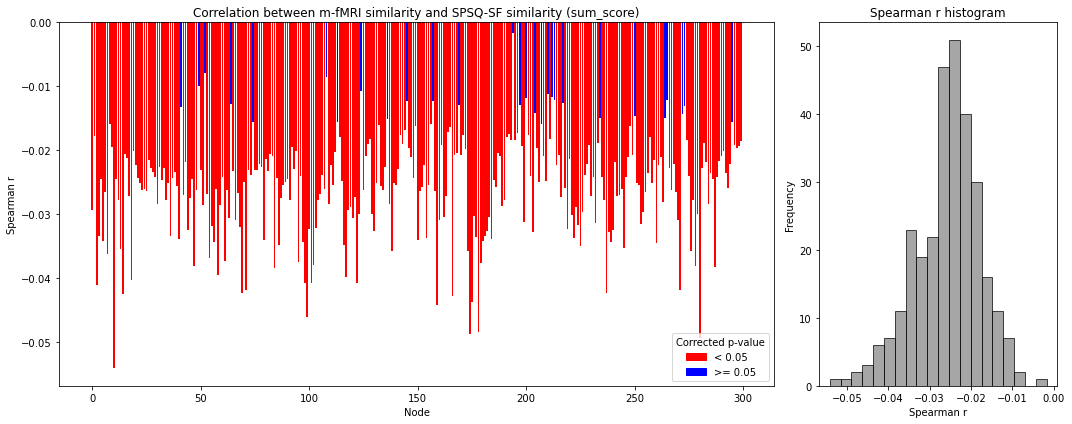

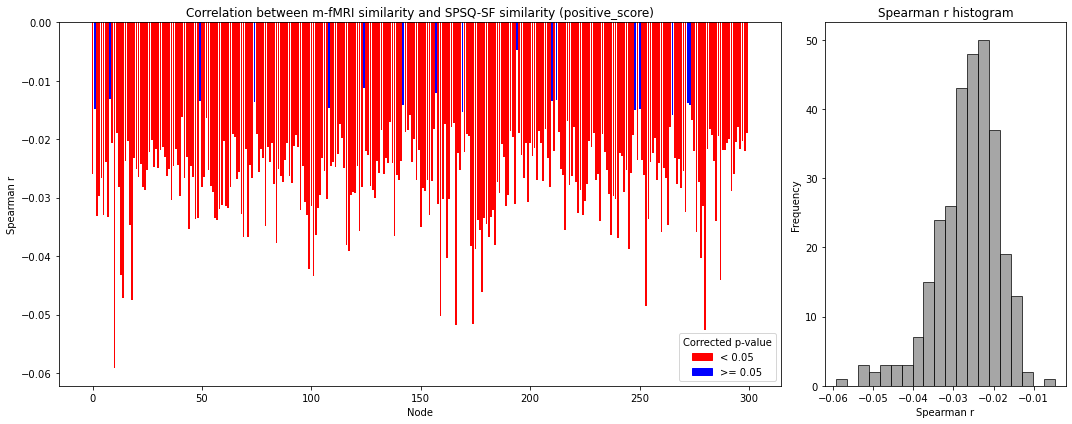

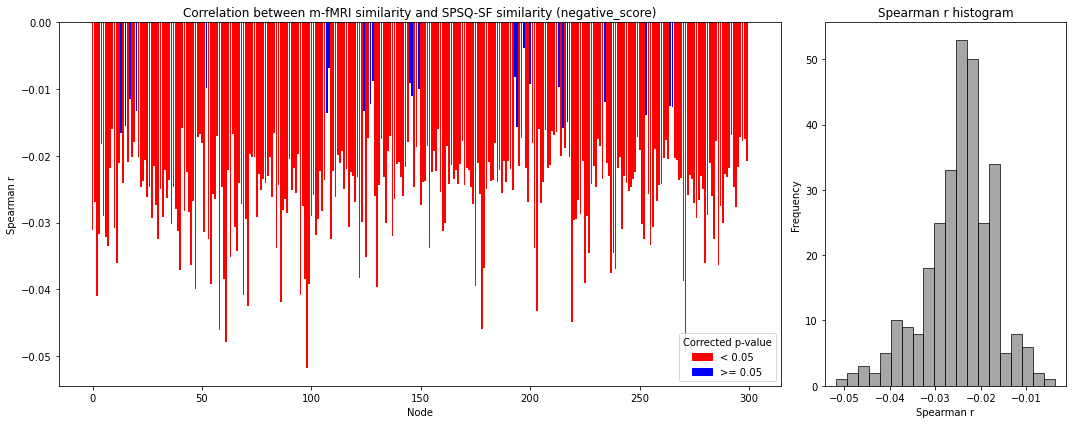

Plots saved as analysis/plots/is-rsa_barplots.pdf


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

# Given parameters
dimensions = ['sum_score', 'positive_score', 'negative_score']
isrsa_dir = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing'

# Create a PDF file to save the plots
pdf_filename = 'analysis/plots/is-rsa_barplots.pdf'
pdf_pages = PdfPages(pdf_filename)

# Loop through each dimension
for dim in dimensions:
    # Load the updated dataframe for the current dimension
    input_filename = os.path.join(isrsa_dir, f'{dim}_isrsa_concat.csv')
    updated_df = pd.read_csv(input_filename)

    # Column names
    spearman_column = 'spearman_r'
    node_column = 'node'
    color_column = 'p_permuted_fdr_fwe3x2'  # Use the new FWE adjusted p-values column

    # Create a custom color list based on the condition
    color_list = ['red' if val < 0.05 else 'blue' for val in updated_df[color_column]]

    # Create the bar plot and histogram subplots with a grid layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

    # Bar plot
    bars = ax1.bar(updated_df[node_column], updated_df[spearman_column], align='center', color=color_list)
    ax1.set_xlabel('Node')
    ax1.set_ylabel('Spearman r')
    ax1.set_title(f'Correlation between m-fMRI similarity and SPSQ-SF similarity ({dim})')

    # Histogram
    ax2.hist(updated_df[spearman_column], bins=20, color='gray', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Spearman r')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Spearman r histogram')

    # Create proxy artists for the legend
    red_patch = mpatches.Patch(color='red', label='< 0.05')
    blue_patch = mpatches.Patch(color='blue', label='>= 0.05')
    
    # Add the legend with a title to the bar plot
    ax1.legend(handles=[red_patch, blue_patch], loc='lower right', title='Corrected p-value')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()
    
    # Save the current figure into the PDF
    pdf_pages.savefig(fig)

    # Close the current figure
    plt.close(fig)

# Close the PDF file
pdf_pages.close()

print(f'Plots saved as {pdf_filename}')


### Brain plot

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



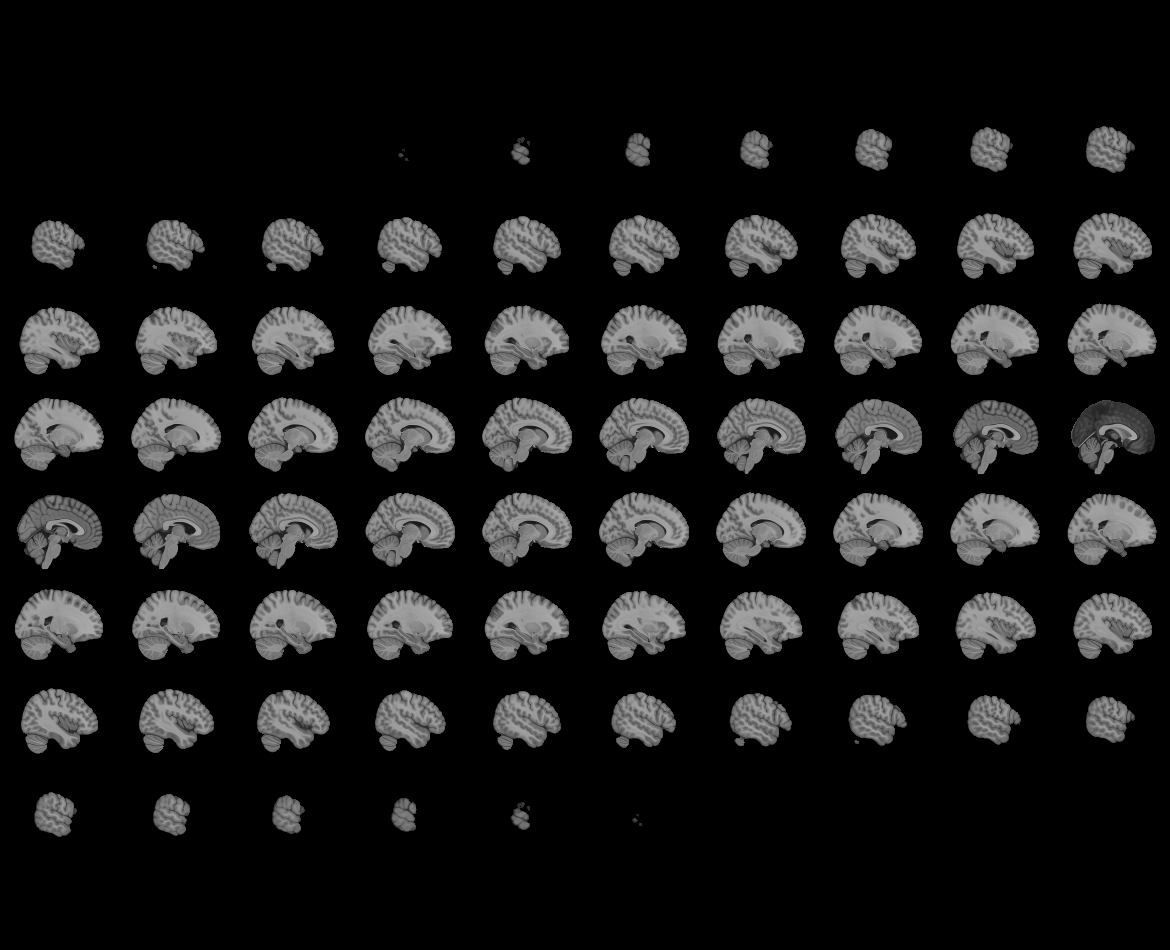
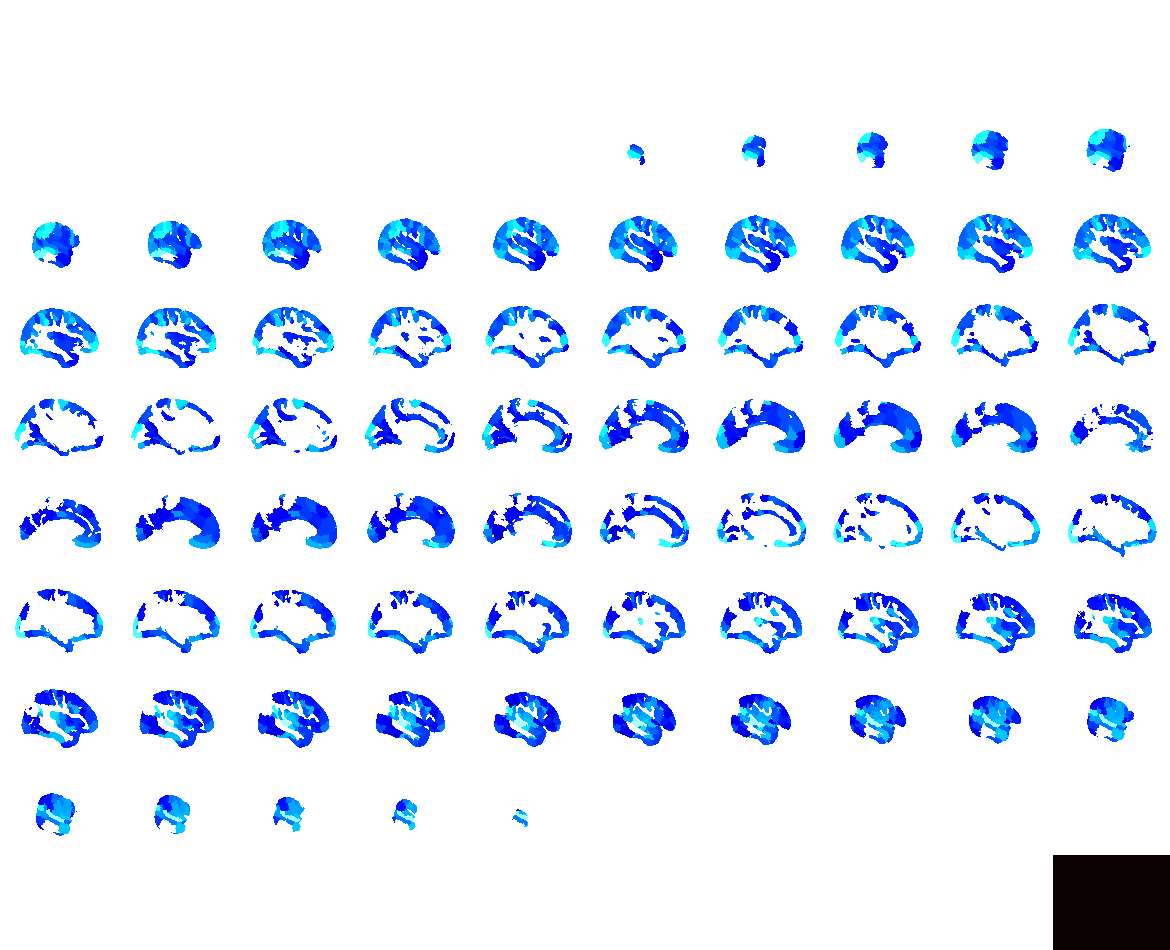

In [121]:
import os
import pandas as pd
from nltools.mask import roi_to_brain, expand_mask
import matplotlib.pyplot as plt
import nibabel as nib
from nltools.data import Brain_Data
import numpy as np
from nltools.stats import fdr
from nilearn.plotting import view_img

# Given parameters
mask_path = 'analysis/Schaefer2018_300Parcels_7Networks_order_FSLMNI152_2mm.nii.gz' 
isrsa_dir = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing'

# Load your mask using nibabel
mask = nib.load(mask_path)

# Load CSV file
csv_path = os.path.join(isrsa_dir, 'sum_score_isrsa_concat.csv')
df = pd.read_csv(csv_path)

# Extract columns from the DataFrame to create 1D arrays
isrsa_sum_score_r = df['spearman_r']
isrsa_sum_score_p = df['p_permuted_fdr_fwe3x2']

# Convert arrays to Brain_Data objects
isrsa_sum_score_r_brain = roi_to_brain(isrsa_sum_score_r, expand_mask(mask))
isrsa_sum_score_p_brain = roi_to_brain(isrsa_sum_score_p, expand_mask(mask))

import numpy as np
from nltools.stats import fdr
import matplotlib.pyplot as plt
from nilearn.plotting import view_img

# Convert isrsa_sum_score_p to a NumPy array
isrsa_sum_score_p_array = isrsa_sum_score_p.to_numpy()

# Replace p-values > 1 with 1
isrsa_sum_score_p_array[isrsa_sum_score_p_array > 1] = 1

# Compute FDR threshold
fdr_thr = fdr(isrsa_sum_score_p_array)

# Apply the threshold to isrsa_sum_score_r_brain using boolean indexing
thresholded_brain_data_sum = isrsa_sum_score_r_brain.copy()
thresholded_brain_data_sum.data = thresholded_brain_data_sum.data * (isrsa_sum_score_p_brain.data < fdr_thr)

# Visualize the thresholded image
view_img(thresholded_brain_data_sum.to_nifti())

/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



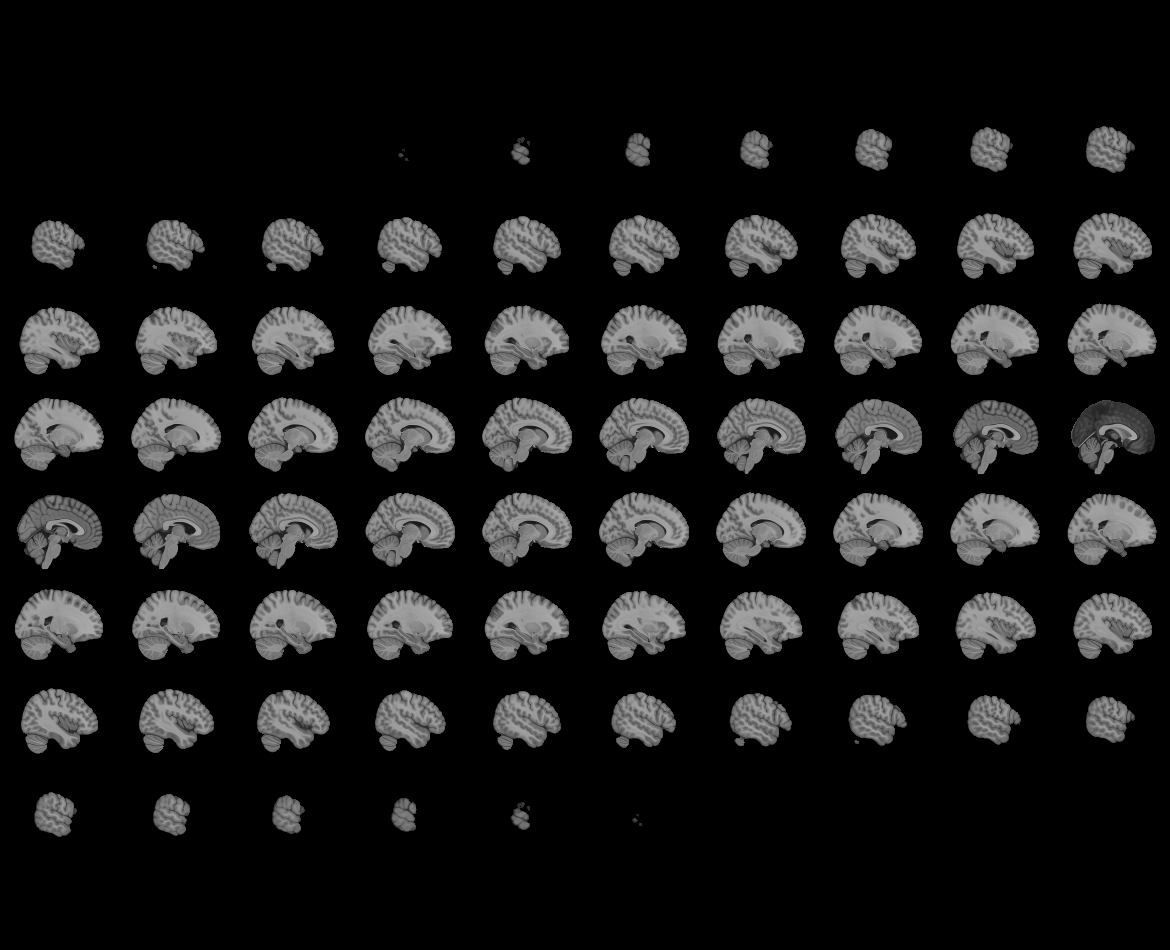
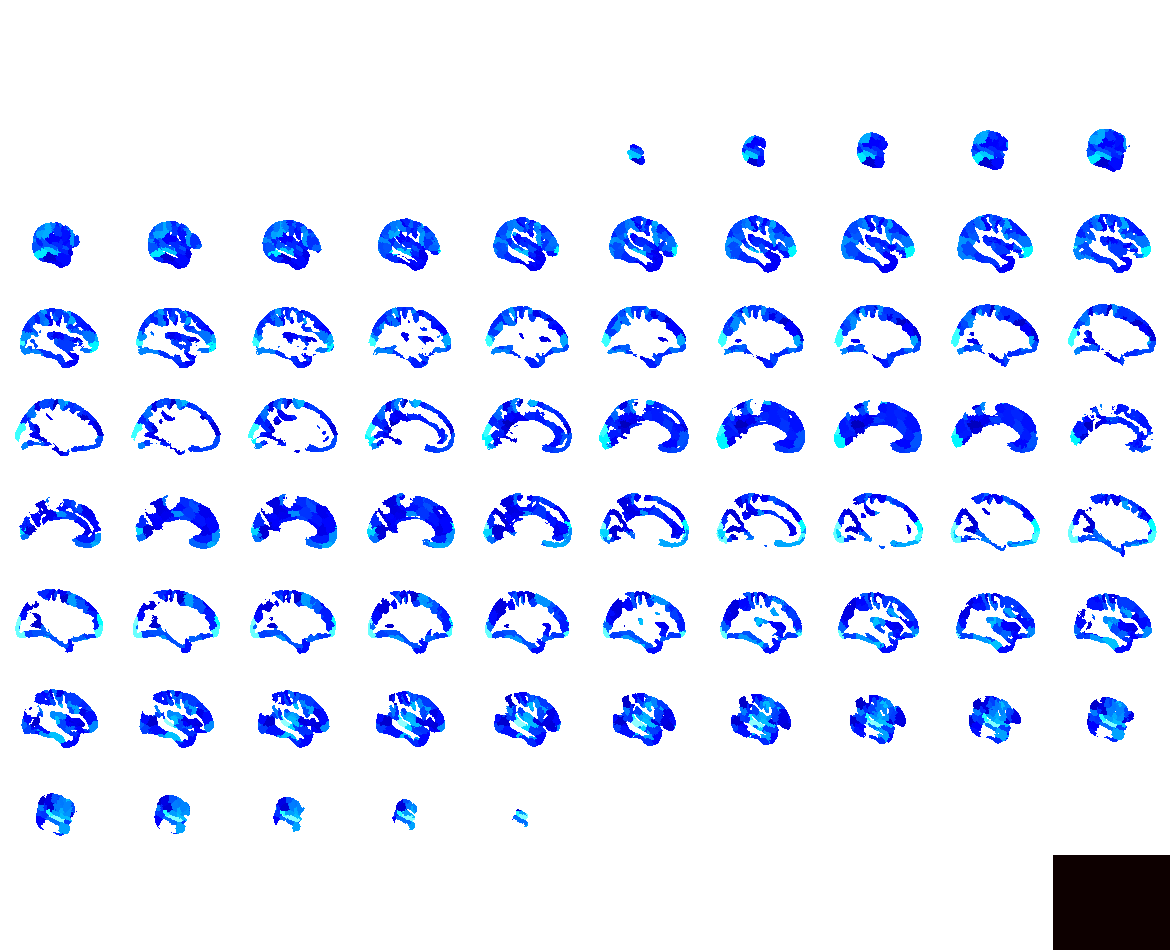

In [119]:
import os
import pandas as pd
from nltools.mask import roi_to_brain, expand_mask
import matplotlib.pyplot as plt
import nibabel as nib
from nltools.data import Brain_Data
import numpy as np
from nltools.stats import fdr
from nilearn.plotting import view_img

# Given parameters
mask_path = 'analysis/Schaefer2018_300Parcels_7Networks_order_FSLMNI152_2mm.nii.gz' 
isrsa_dir = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing'

# Load your mask using nibabel
mask = nib.load(mask_path)

# Load CSV file
csv_path = os.path.join(isrsa_dir, 'positive_score_isrsa_concat.csv')
df = pd.read_csv(csv_path)

# Extract columns from the DataFrame to create 1D arrays
isrsa_positive_score_r = df['spearman_r']
isrsa_positive_score_p = df['p_permuted_fdr_fwe3x2']

# Convert arrays to Brain_Data objects
isrsa_positive_score_r_brain = roi_to_brain(isrsa_positive_score_r, expand_mask(mask))
isrsa_positive_score_p_brain = roi_to_brain(isrsa_positive_score_p, expand_mask(mask))

import numpy as np
from nltools.stats import fdr
import matplotlib.pyplot as plt
from nilearn.plotting import view_img

# Convert isrsa_sum_score_p to a NumPy array
isrsa_positive_score_p_array = isrsa_positive_score_p.to_numpy()

# Replace p-values > 1 with 1
isrsa_positive_score_p_array[isrsa_positive_score_p_array > 1] = 1

# Compute FDR threshold
fdr_thr = fdr(isrsa_positive_score_p_array)

# Apply the threshold to isrsa_sum_score_r_brain using boolean indexing
thresholded_brain_data_positive = isrsa_positive_score_r_brain.copy()
thresholded_brain_data_positive.data = thresholded_brain_data_positive.data * (isrsa_positive_score_p_brain.data < fdr_thr)

# Visualize the thresholded image
view_img(thresholded_brain_data_positive.to_nifti())


/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/posdevpsy/chrgon/.local/lib/python3.8/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



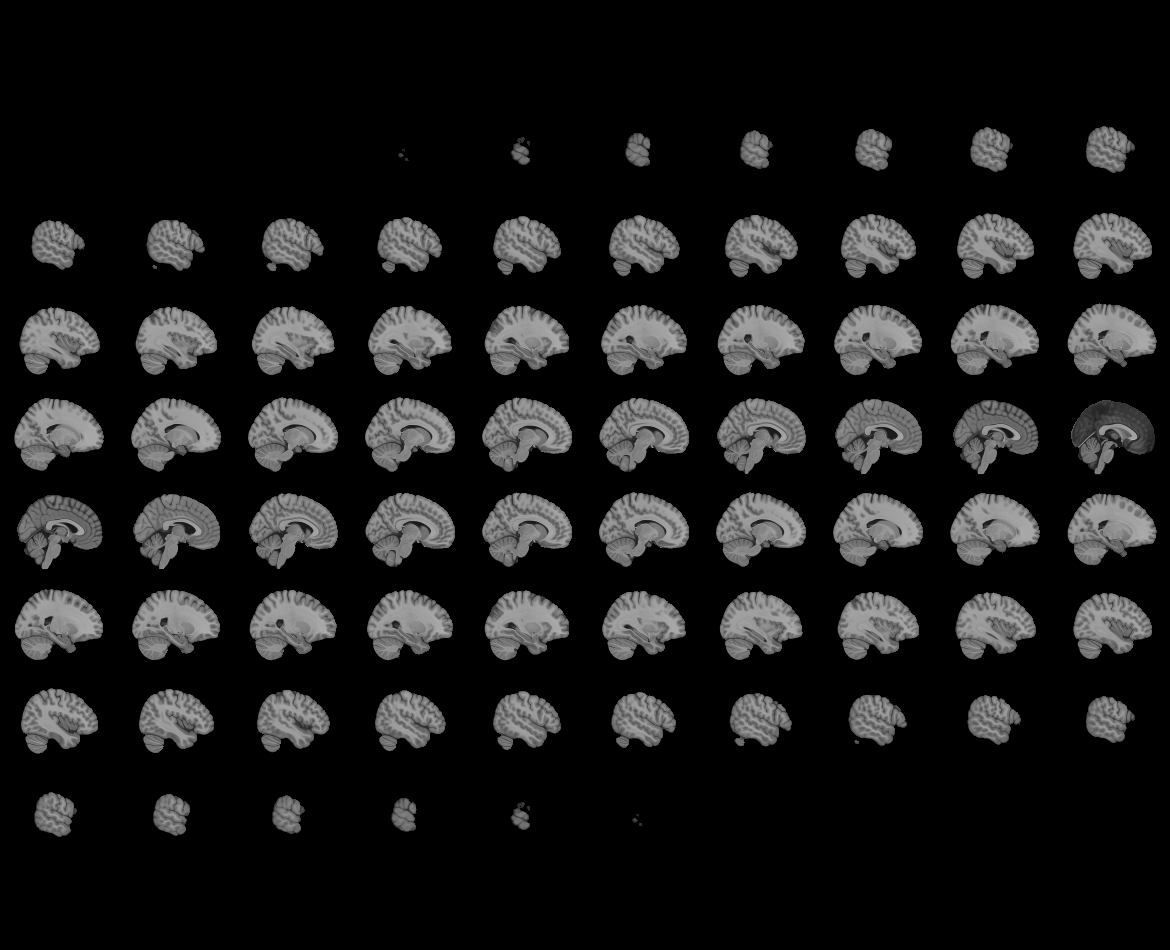
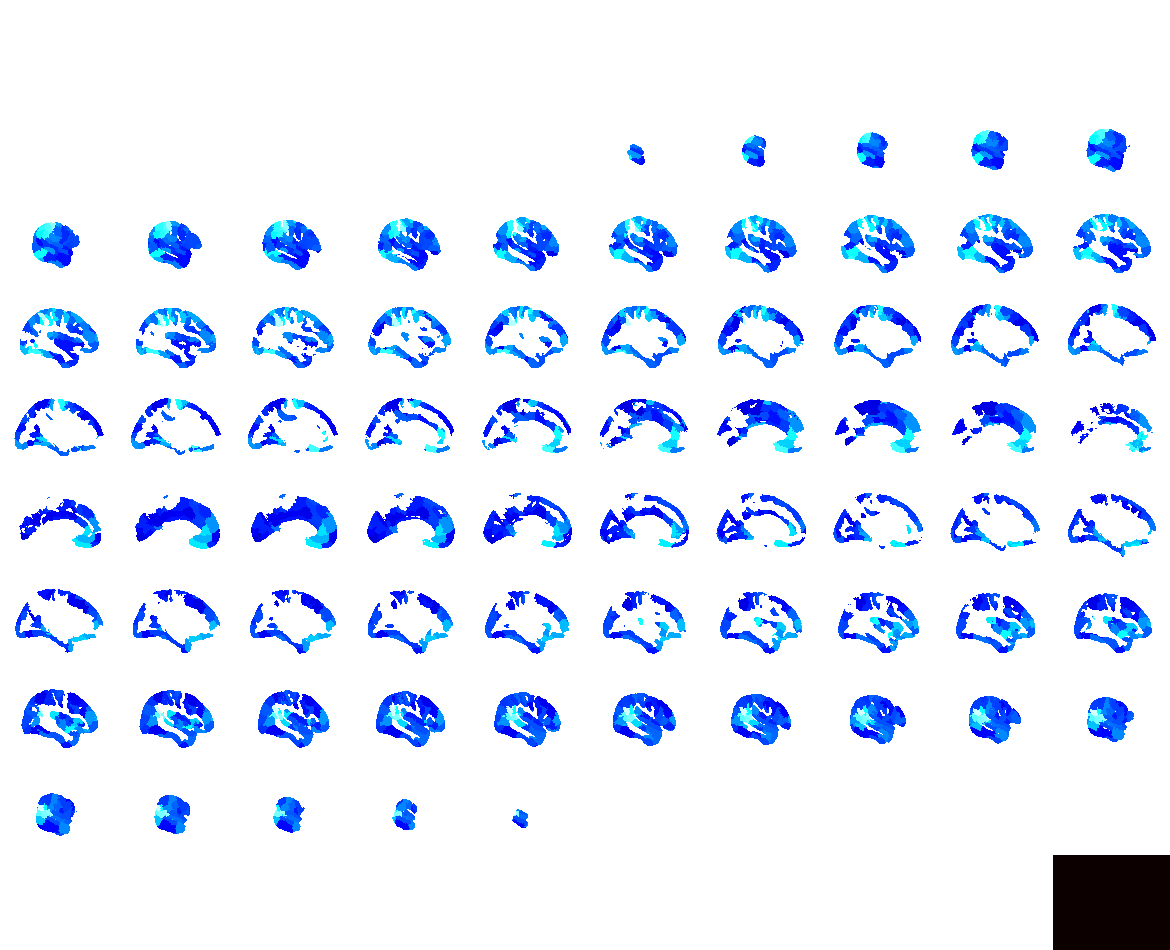

In [117]:
import os
import pandas as pd
from nltools.mask import roi_to_brain, expand_mask
import matplotlib.pyplot as plt
import nibabel as nib
from nltools.data import Brain_Data
import numpy as np
from nltools.stats import fdr
from nilearn.plotting import view_img

# Given parameters
mask_path = 'analysis/Schaefer2018_300Parcels_7Networks_order_FSLMNI152_2mm.nii.gz' 
isrsa_dir = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing'

# Load your mask using nibabel
mask = nib.load(mask_path)

# Load CSV file
csv_path = os.path.join(isrsa_dir, 'negative_score_isrsa_concat.csv')
df = pd.read_csv(csv_path)

# Extract columns from the DataFrame to create 1D arrays
isrsa_negative_score_r = df['spearman_r']
isrsa_negative_score_p = df['p_permuted_fdr_fwe3x2']

# Convert arrays to Brain_Data objects
isrsa_negative_score_r_brain = roi_to_brain(isrsa_negative_score_r, expand_mask(mask))
isrsa_negative_score_p_brain = roi_to_brain(isrsa_negative_score_p, expand_mask(mask))

import numpy as np
from nltools.stats import fdr
import matplotlib.pyplot as plt
from nilearn.plotting import view_img

# Convert isrsa_sum_score_p to a NumPy array
isrsa_negative_score_p_array = isrsa_negative_score_p.to_numpy()

# Replace p-values > 1 with 1
isrsa_negative_score_p_array[isrsa_negative_score_p_array > 1] = 1

# Compute FDR threshold
fdr_thr = fdr(isrsa_negative_score_p_array)

# Apply the threshold to isrsa_sum_score_r_brain using boolean indexing
thresholded_brain_data_negative = isrsa_negative_score_r_brain.copy()
thresholded_brain_data_negative.data = thresholded_brain_data_negative.data * (isrsa_negative_score_p_brain.data < fdr_thr)

# Visualize the thresholded image
view_img(thresholded_brain_data_negative.to_nifti())


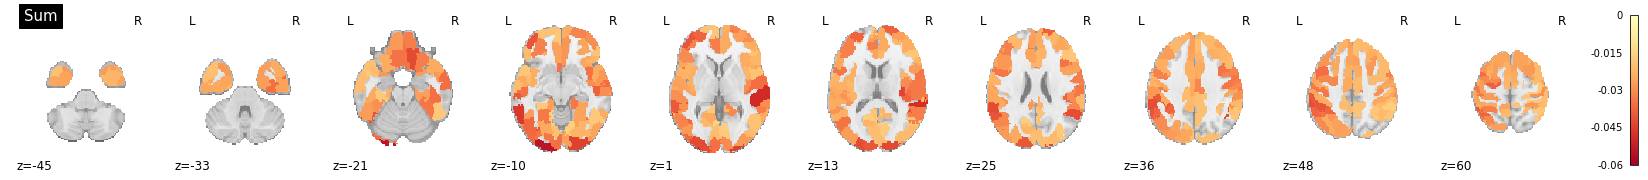

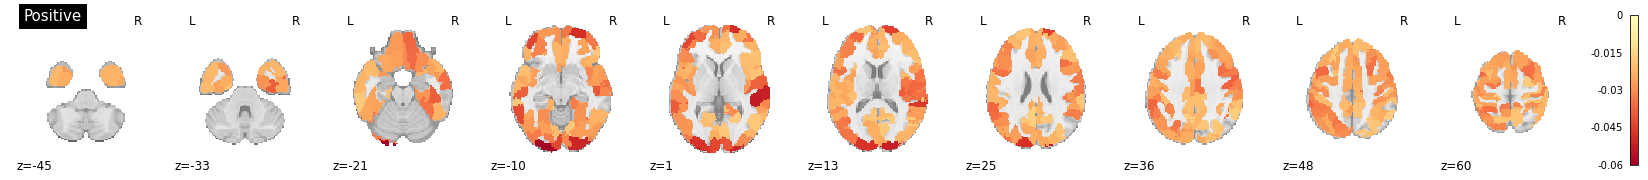

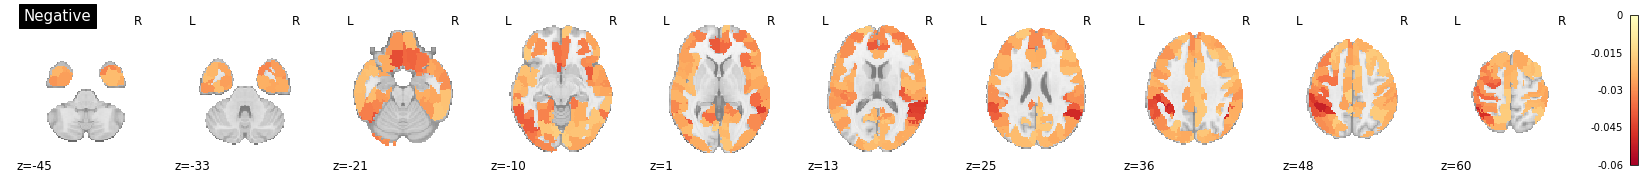

In [145]:
import numpy as np
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt

# Calculating the maximum absolute magnitude
#vmax_sum = np.max(np.abs(isrsa_sum_score_r))
#vmax_positive = np.max(np.abs(isrsa_positive_score_r))
#vmax_negative = np.max(np.abs(isrsa_negative_score_r))

common_cut_coords = np.linspace(-45, 60, num=10) 

sum_plot=plot_stat_map(thresholded_brain_data_sum.to_nifti(), display_mode='z', cut_coords=common_cut_coords, vmax=0.06, title="Sum", cmap='RdYlBu')
positive_plot=plot_stat_map(thresholded_brain_data_positive.to_nifti(), display_mode='z', cut_coords=common_cut_coords, vmax=0.06, title="Positive", cmap='RdYlBu')
negative_plot=plot_stat_map(thresholded_brain_data_negative.to_nifti(), display_mode='z', cut_coords=common_cut_coords, vmax=0.06, title="Negative", cmap='RdYlBu')

### Polar

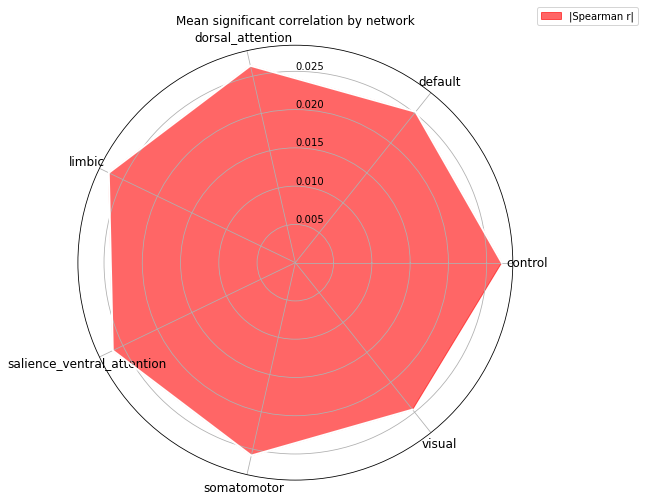

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
csv_file = 'analysis/inter-subject_representational_similarity_analysis/throughout_movie-viewing/negative_score_isrsa_concat.csv'
df = pd.read_csv(csv_file)

# Filter rows where p_permuted_fdr_fwe3x2 < 0.05
filtered_df = df[df['p_permuted_fdr_fwe3x2'] < 0.05]

# Sort the filtered data by the 'network' column
sorted_df = filtered_df.sort_values(by='network')

# Normalize 'spearman_r' values to be positive
sorted_df['spearman_r_abs'] = sorted_df['spearman_r'].abs()

# Aggregate the data by network
aggregated_data = sorted_df.groupby('network')['spearman_r_abs'].mean().reset_index()

# Create a polar plot
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Calculate the angle for each network
unique_networks = aggregated_data['network'].unique()
num_networks = len(unique_networks)
angles = np.linspace(0, 2 * np.pi, num_networks, endpoint=False)

# Plot the aggregated data points with red fill
radii = aggregated_data['spearman_r_abs'].tolist()

# Create a white background circle that fills the entire plot
ax.fill_between(angles, 0, max(radii), color='white', alpha=1)

# Plot the data points with red fill
ax.fill(angles, radii, color='red', alpha=0.6, label='|Spearman r|')

# Plot white coordinate lines
ax.plot(angles, radii, linestyle='-', color='white', linewidth=2)

# Customize the plot
ax.set_xticks(angles)
ax.set_xticklabels(unique_networks, fontsize=12)
ax.set_rlabel_position(90)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Mean significant correlation by network')

# Show the plot
plt.show()


### Next: Threat vs. neutral